In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distr

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

### Dataset definition

In [2]:
batch_size = 100
num_workers = 4

# Transforms
transform = transforms.ToTensor()

# Train
train_mnist = datasets.MNIST("./data", train=True, transform=transform)
train_loader = DataLoader(train_mnist, shuffle=True, batch_size=batch_size, num_workers=num_workers)

# Test
test_mnist = datasets.MNIST("./data", train=False, transform=transform)
test_loader = DataLoader(test_mnist, shuffle=True, batch_size=batch_size, num_workers=num_workers)

### Network definition

In [3]:
class Encoder(nn.Module):
    def __init__(self, l0, l1):
        super(Encoder, self).__init__()
         
        # Define layers
        self.fc0 = nn.Linear(28*28, l0)
        self.fc1_mu = nn.Linear(l0, l1)
        self.fc1_sigma = nn.Linear(l0, l1)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        # Hidden
        x = self.fc0(x)
        x = F.relu(x)
        
        # Latent
        mu = self.fc1_mu(x)
        logvar = self.fc1_sigma(x)
        
        return mu, logvar 
        
class Decoder(nn.Module):
    def __init__(self, l0, l1):
        super(Decoder, self).__init__()
        
        # Define layers
        self.fc0 = nn.Linear(l0, l1)
        self.fc1 = nn.Linear(l1, 28*28)
        
    def forward(self, x):
        
        # Hidden
        x = self.fc0(x)
        x = F.relu(x)
        
        # Output
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = x.view(x.shape[0], 1, 28, 28)
        
        return x
        
class VAE(nn.Module):
    def __init__(self, l0, l1):
        super(VAE, self).__init__()
        self.encoder = Encoder(l0, l1)
        self.decoder = Decoder(l1, l0)
        
    def forward(self, x):
        # Generate deterministic mean and std
        z_mu, z_logvar = self.encoder(x)
        
        # Sample epsilon and make z stochastic
        eps = torch.randn_like(z_logvar)
        z_sigma = torch.exp(0.5 * z_logvar)
        z = z_mu + z_sigma * eps
        
        # Perform decoding, or sample from X
        y = self.decoder(z)
        
        return y, z_mu, z_logvar

### Loss definition

In [4]:
def ELBO(mu, logvar, output, input):
    reconstruction_error = F.binary_cross_entropy(output, input, reduction="sum")
    kld = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).sum()
    return reconstruction_error + kld

### Training

In [5]:
gpu = False

if gpu:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = VAE(400, 20)
optimizer = optim.Adam(model.parameters())
model.to(device)

epochs = 100
for _ in range(epochs):
    bar = tqdm(total=len(train_loader))
    for b_idx, batch in enumerate(train_loader):
        # Forward
        x, _ = batch
        x = x.to(device)
        net_x, z_mu, z_logvar = model(x)
        
        # Loss
        loss = ELBO(z_mu, z_logvar, net_x, x)
        loss.backward()
        optimizer.step()
        
        # Update loss in tqdm
        postfix_str = f"Current loss {loss.item()}"
        bar.set_description(desc=postfix_str)
        bar.update()
        
        # Plot image for debugging purpose
        if (b_idx % 100) == 0:
            plt.imshow(net_x.detach()[0, 0, ...])
        
    bar.close()

Current loss 33404.96875: 100%|██████████| 600/600 [00:14<00:00, 42.74it/s]    


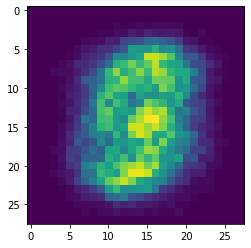

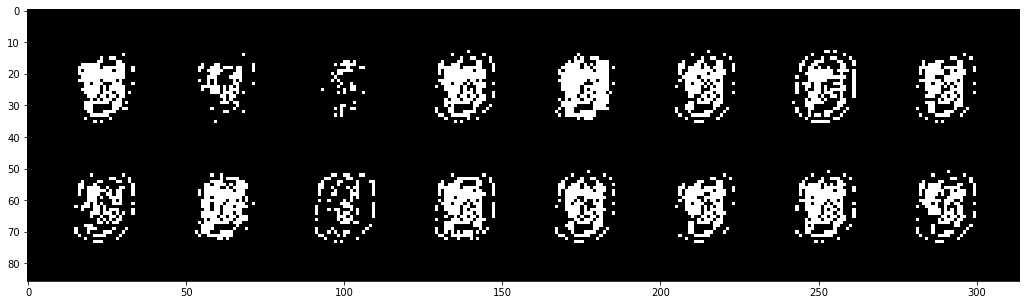

In [6]:
# Show samples
sample = torch.randn(16, 20)
sample = model.decoder(sample.to(device)).cpu().detach()
ims = make_grid(sample, nrow=8, padding=10)
ims = ims.numpy()

plt.figure(figsize=(20, 5))
plt.imshow(np.transpose(ims, (1, 2, 0)), interpolation="nearest")
plt.show()